# Text Analysis 

In [1]:
from bs4 import BeautifulSoup 
import requests
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
import os
import string
import nltk 
from  nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Scraping

In [2]:
page = requests.get("https://insights.blackcoffer.com/what-if-the-creation-is-taking-over-the-creator/")

In [3]:
soup = BeautifulSoup(page.text, "html.parser")

In [4]:
div = soup.find('div', class_ ="td-post-content tagdiv-type" )

In [5]:
article = [p.text.strip() for p in div.find_all('p')]

In [6]:
article[0]

'Human minds, a fascination in itself carrying the potential of tinkering nature with the pixie dust intelligence, creating and solving the mysteries and wonders with anything but admiration. However, no matter how captivating a human mind can be, it could sometimes be appalled. It could be the hunger or maybe the desire to want more, to go beyond and unravel the limitations, or maybe something like pure greed. Humans have never stopped and always keep evolving when it comes to intelligence and this is what makes them the supreme.'

## Text Analysis 

### Load  stop words

Our stop words include predefined dictionary for stop words (auditor, currencies, dates and numbers, geographic, names, ... ) and nltk stop words. 

Those words are not generally included in sentiment analysis. 

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
    #Create a set for stopwords
stopwords_path = "C:/Users/USER/Desktop/IIT/Dataset/Text analysis/2/DICT/stopwrods"
stop_words = set()

    #Iterate over each file
for filename in os.listdir(stopwords_path):
        with open(os.path.join(stopwords_path, filename), "r") as file :
                for line in file: 
                        stop_words.add(line.strip().lower())

    #Add NLTK stopwords 
stop_words.update(stopwords.words('english'))          

In [9]:
print("There are ", len(stop_words) , " stop words (NLTK stopwords in the english words included). ")

There are  12793  stop words (NLTK stopwords in the english words included). 


### Text cleaning function

Through this step, we will store the cleaned tokens which are the words from our articles excluded the stop words. 

In [10]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
    #Define text cleaning function
def clean_text(text):
        #tokenize text
        tokens = word_tokenize(text.lower())
        #remove stopwords and punctuations
        cleaned_tokens = [word for word in tokens 
                          if word not in stop_words 
                          and word not in string.punctuation]
        return cleaned_tokens

In [12]:
    #Apply the text cleaning function and store the tokens into a list
cleaned_tokens = []
for text in article:
        cleaned_tokens.extend(clean_text(text))

In [13]:
len(cleaned_tokens)

566

The article contains 566 cleaned tokens, which are the words used for sentiment analysis

### Sentiment Analysis 

#### Load the dictionary of positive and negative words 

In [14]:
pos_words = set()
neg_words = set()
master_dict_path = "C:/Users/USER/Desktop/IIT/Dataset/Text analysis/2/DICT/MasterDict"

with open(os.path.join(master_dict_path, "positive-words.txt"),'r') as file :
        pos_words.update([line.strip().lower() for line in file 
                                    if line.strip().lower() not in stop_words])
 
with open(os.path.join(master_dict_path, "negative-words.txt"),'r') as file :
        neg_words.update([line.strip().lower() for line in file 
                                    if line.strip().lower() not in stop_words])
        

In [15]:
print("There are ", len(pos_words), "words in the positive words dictionary")
print("There are ", len(neg_words), "words in the negative words dictionary")

There are  1906 words in the positive words dictionary
There are  4693 words in the negative words dictionary


#### Positive and Negative score

For each word from the clean tokens, we will attribute a score if they are found in the positive or the negative dictionary. 

In [16]:
positive = []
for word in pos_words :
        if word in cleaned_tokens : 
                positive.append(word)
                
negative = []
for word in neg_words :
        if word in cleaned_tokens : 
                negative.append(word)

In [17]:
print("Total positive score :", len(positive))
print("Total negative score :", len(negative))


Total positive score : 37
Total negative score : 29


####  Word Cloud of the positive and negative words

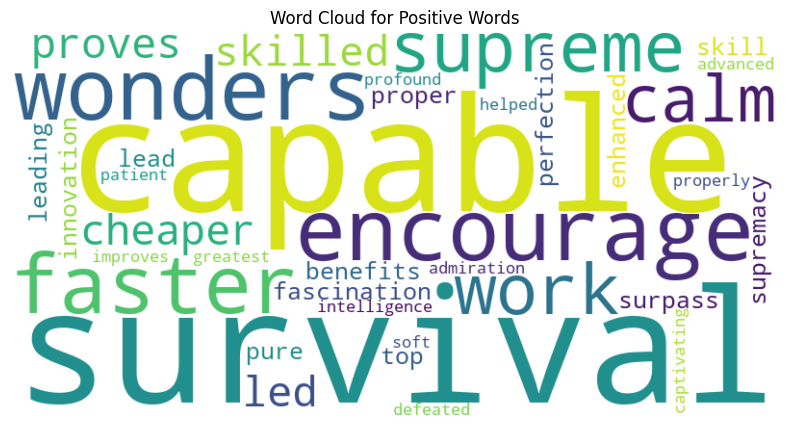

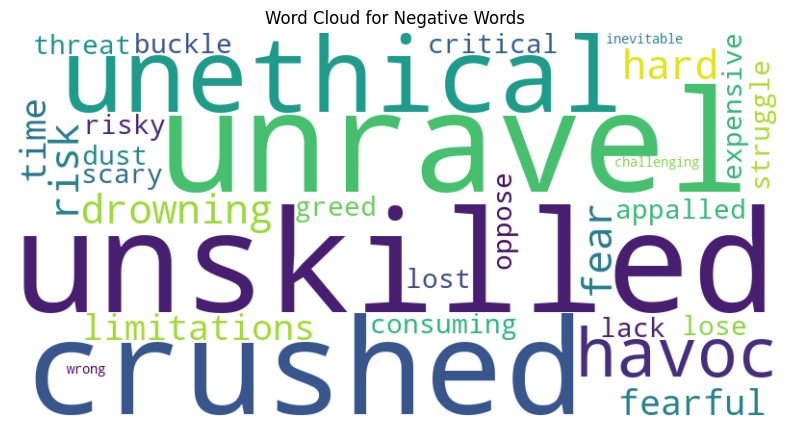

In [18]:
def word_cloud(text, title):
        wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(' '.join(text))
        plt.figure(figsize = (10,5))
        plt.imshow(wordcloud, interpolation = "bilinear")
        plt.axis("off")
        plt.title(title)
        plt.show()

word_cloud(positive, "Word Cloud for Positive Words")
word_cloud(negative,  "Word Cloud for Negative Words")



#### Polarity score

The polarity score is given by : 

$$
polarity = \frac{positive-negative}{(positive+negative)+\varepsilon}
$$

In [19]:
polarity = (len(positive)-len(negative))/((len(positive)+len(negative))+0.00001)
print("The polarity score is :", polarity)

The polarity score is : 0.12121210284665108


The polarity score ranges from -1 and +1. Thus, the polarity score of 0.12 suggests that the text has a slightly positive sentiment. 

#### Subjectivity score

The subjectivity score is given by :

$$
subjectivity = \frac{positive+negative}{Total \ of \ words \ after \ cleaning}
$$

In [20]:
subjectivity = (len(positive)+len(negative))/len(cleaned_tokens)
print("The subjectivity score is :", subjectivity)

The subjectivity score is : 0.1166077738515901


The subjectivity score typically ranges from 0 to 1. 
A score closer to 0 suggests that the text is more objective while a score closer to 1 suggests a more subjective one. 

In our case, a subjectivity score of 0.11 suggests that the text is mostky objective, containing factual statements rather than opinions or subjective expressions. 

### Readability

The readability of a text can be evaluated using the **Gunning Fog Index metric.** 
By assessing readability, we can enhance the accessibility of a given text and ensure compliance with standards in various fields.

The Gunning Fog Index is given by 

$$
Gunning \ Fog \ index = 0.4 \ * \ (Average \ sentence \ length + Percentage \ of \ long \ words)
$$

#### Average sentence length

It is given by :

$$ 
Average \ sentence \ length = \frac{number \ of \ words}{number \ of \ sentences}
$$


Let us implement a function to figure out the number of sentences and words

In [21]:
    #Load pre-trained pipeline from SpaCy 
nlp = spacy.load("en_core_web_sm")

In [22]:
def extract_sentences_words(text):
        doc = nlp(text)
        sentences = [sent.text for sent in doc.sents]
        words = [token.text for token in doc if token.is_alpha]
        return sentences, words
    

In [23]:
    #Apply the function on the string object of the article dataframe
mysentences, mywords = extract_sentences_words(' '.join(article))

In [24]:
    #Check out the first 10 sentences 
for i in range(0,10):
        print(mysentences[i]) 

Human minds, a fascination in itself carrying the potential of tinkering nature with the pixie dust intelligence, creating and solving the mysteries and wonders with anything but admiration.
However, no matter how captivating a human mind can be, it could sometimes be appalled.
It could be the hunger or maybe the desire to want more, to go beyond and unravel the limitations, or maybe something like pure greed.
Humans have never stopped and always keep evolving when it comes to intelligence and this is what makes them the supreme.
Intelligence calls out for supremacy and so, what if there was to evolve something that opposed a challenge to the very human minds, to their capabilities while making them question their own importance among themselves?
Artificial Intelligence came as a revolution, havoc when it first came to the light.
The concept of making machines does work on their own, like granting machines –The Intelligence.
The idea of making machines work like humans came back in the

In [25]:
    #Check out the first 10 words 
for i in range(0,11):
        print(mywords[i]) 

Human
minds
a
fascination
in
itself
carrying
the
potential
of
tinkering


In [26]:
print("The total number of words in the article is:" , len(mywords))
print("The total number of sentences in the article is:" , len(mysentences))

The total number of words in the article is: 1405
The total number of sentences in the article is: 79


In [27]:
    #The average sentence length 
avg_sentence_len = len(mywords)/len(mysentences)
print("The average sentence length is : ", avg_sentence_len)

The average sentence length is :  17.78481012658228


There are in average 18 words in each sentence in the article. 

#### Percentage of long words 

It is given by : 

$$
Percentage \ of \ long \ words = \frac{long \ words }{Number \ of \ Words} * 100
$$

Long words are words having more than 2 syllables.

Then, let us define a syllables counters function and apply it on the words in the article. 

In [28]:
def syllable_count(word):
        word = word.lower()
        count = 0
        vowels = "aeiouy"
        
            #Check the first character
        if word[0] in vowels : 
                count +=1
                
        for index in range(1,len(word)):
            #Prevent counting multiple consecutive vowels as separate syllables
                if word[index] in vowels and word[index-1] not in vowels :
                        count+=1
            #Handle the exceptions (words ending with -es and -ed)
        if word.endswith("es") or word.endswith("ed"):
                count-=1
            #Ensure that the function returns at least 1 syllable
        return max(1,count)

In [29]:
    #Apply the syllables counters
long_words = []
for word in mywords :
        syllable_count(word)
        if syllable_count(word) > 2:
                long_words.append(word)

In [30]:
print("The number of long words is :", len(long_words))

The number of long words is : 210


In [31]:
    #Check out the first 10 complex words 
for i in range(0,10):
        print(long_words[i])

fascination
potential
tinkering
nature
intelligence
anything
admiration
However
captivating
sometimes


In [32]:
    #Percentage of long words 
perc_long_words = len(long_words)*100/len(mywords)
print("The percentage of long words is :", perc_long_words)

The percentage of long words is : 14.946619217081851


15% of the words in the article have more than 2 syllables and can be considered as long words. 


#### The Gunning Fog index 

The Gunning Fog index is a readability metric designed to extimate the complexity of English text. 
It determines how many years of formal eductation a person needs to understand a given piece of writing on the first reading. 

Recall : 

$$
Gunning \ Fog \ index = 0.4 \ * \ (Average \ sentence \ length + Percentage \ of \ long \ words)
$$

**Interpretation**:

    - Index score 6 to 10 : easily readable
    - Index score 10 to 12 : acceptable for a wide audiance
    - Index score 12 to 15 : more challenging, suitable for readers with some college eduction
    - Index score 15 to 20 : Difficult to read, suitable for readers with college degrees
    - Index score 20+ : Very complex, best understood by experts or readers with advanced degrees

In [33]:
fog_index = 0.4*(avg_sentence_len+perc_long_words)
print("The Gunning Fog index is :", fog_index)

The Gunning Fog index is : 13.092571737465654


In our case, the article has a Gunning Fog Index of 13, indicating it is aimed at readers with some college education.